c:\Users\20212358\AppData\Local\Programs\Python\Python310\lib\site-packages\cp_measure\core\measureobjectsizeshape.py:637: RuntimeWarning: divide by zero encountered in divide
  formfactor = 4.0 * numpy.pi * props["area"] / props["perimeter"] ** 2


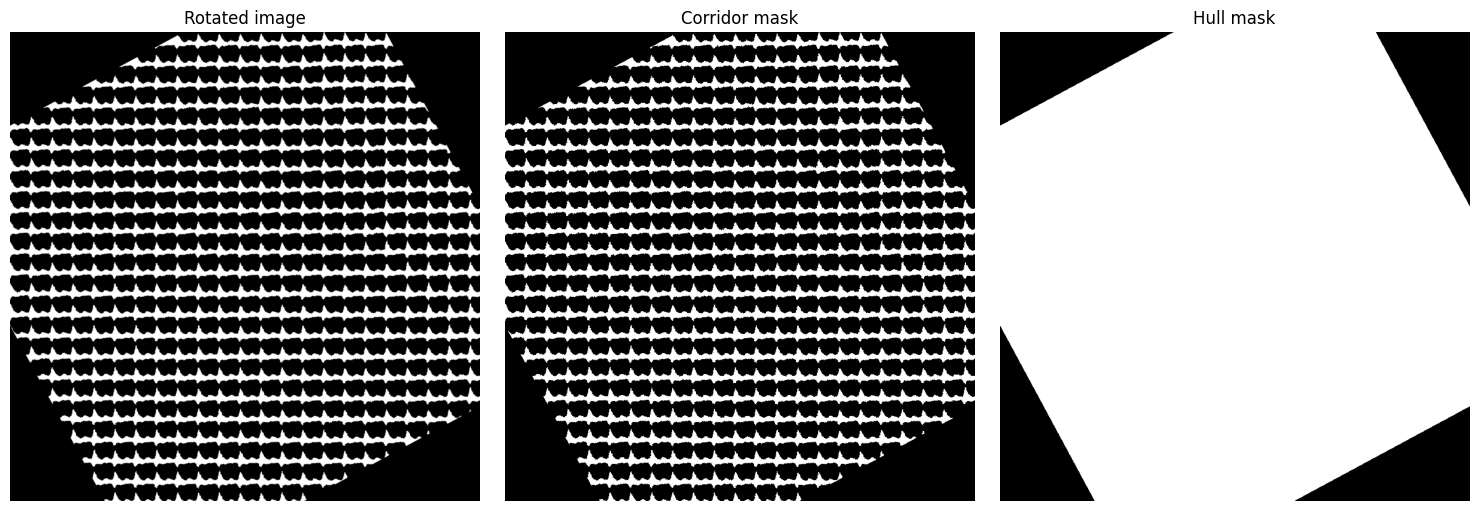

Detected rotation: 28.341 degrees
Detected 23 corridors.
Using corridor #0 as reference corridor.
Reference corridor index: 0, x0_ref: 440
Total matched windows: 522


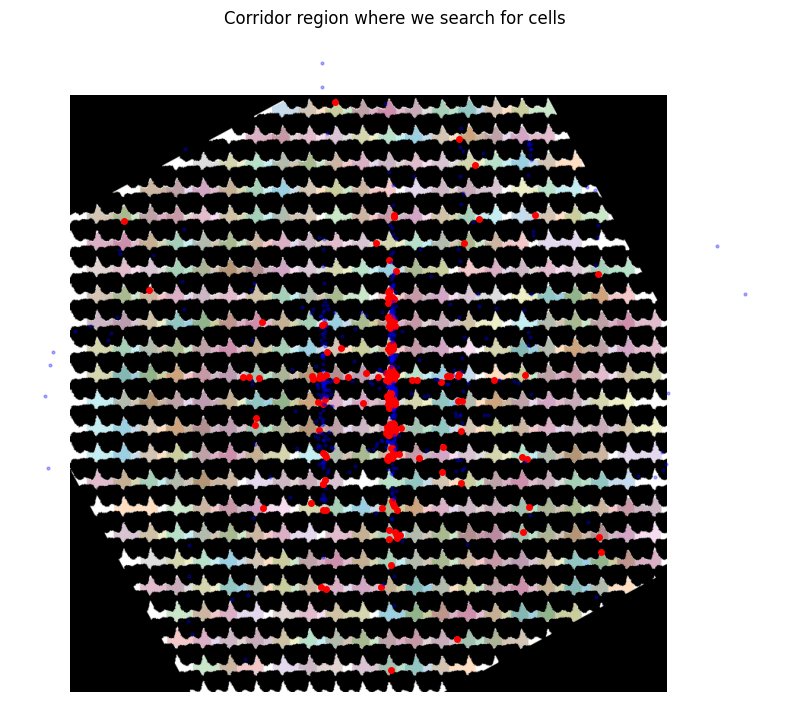

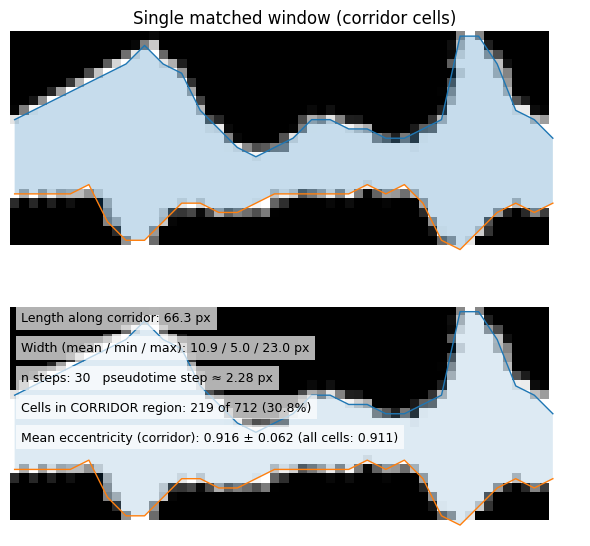

In [21]:
from tifffile import imread
from morphology_pipeline import pipeline_windows as pw

# 1) фон (background TopoChip)
background = r"C:\Users\20212358\OneDrive - TU Eindhoven\pseudotime_GitHUB\input images\FeatureIdx_1462.tif"
img = imread(background)

# если RGBA → отрезаем альфа-канал
if img.ndim == 3 and img.shape[-1] == 4:
    img = img[..., :3]

# 2) папка с DAPI/YAP/actin
folder = r"C:\Users\20212358\Downloads\Nikita PhD BAZA\Chip_1462_1_real"

# 3) запускаем новый pipeline_windows
SD, mask, selected, window_infos, centers_rot_map, rot_img = pw.run_pipeline_and_save_csvs(
    img,
    x0_ref=None,       # или конкретный x0, например 400
    cor_ref="top",     # None | "top" | "bottom" | int
    folder=folder,
)


In [6]:
# 1) Build cells_corridor with eccentricity as the feature
cells_corridor, total_len = pw.build_cells_corridor(
    SD=SD,
    centers_rot_map=centers_rot_map,
    window_infos=window_infos,
    mask=mask,
    feature_cols=["eccentricity"],   # you can add more later
)
print(f"Number of corridor cells: {len(cells_corridor)}")
print(f"Total corridor length: {total_len:.1f} px")


Number of corridor cells: 219
Total corridor length: 34759.6 px


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from morphology_pipeline import pipeline_windows as pw

def find_extreme_ecc_regions(
    cells_corridor,
    total_len,
    window_width_px=1000.0,
    step_px=500.0,
    N_BINS=18,
    MIN_WINDOWS_PER_BIN=2,
    MIN_CELLS_PER_BIN=10,
):
    """
    1) Build sliding-window profile of eccentricity along the corridor
       using pw.corridor_feature_profile_sliding.
    2) Bin pseudotime into N_BINS.
    3) For each bin, compute the median of window means.
    4) Among bins with enough windows+cells, pick one with
       minimum median (A) and one with maximum median (B).
    """

    # --- 1. sliding-window profile over the corridor -------------------
    df_slide = pw.corridor_feature_profile_sliding(
        cells_corridor,
        total_len,
        feature_key="eccentricity",
        window_width_px=window_width_px,
        step_px=step_px,
    )

    # normalize pseudotime 0–1
    df_slide["pseudo01"] = df_slide["center_s"] / total_len

    # --- 2. bin sliding windows along pseudotime -----------------------
    bins = np.linspace(0.0, 1.0, N_BINS + 1)
    df_slide["bin"] = pd.cut(
        df_slide["pseudo01"],
        bins=bins,
        labels=False,
        include_lowest=True,
    )

    # binned summary: median of window means, how many windows/cells
    prof = (
        df_slide.groupby("bin")
        .agg(
            pseudo01=("pseudo01", "mean"),
            median_ecc=("mean_val", "median"),   # median of window means
            n_windows=("mean_val", "size"),
            n_cells=("n_cells", "sum"),
        )
        .dropna(subset=["pseudo01"])
    )

    # keep only "reliable" bins
    valid = prof[
        (prof["n_windows"] >= MIN_WINDOWS_PER_BIN)
        & (prof["n_cells"] >= MIN_CELLS_PER_BIN)
    ].copy()

    if valid.empty:
        raise RuntimeError("No bins with enough windows/cells to define regions A and B.")

    # --- 3. pick extreme bins ------------------------------------------
    bin_A = int(valid["median_ecc"].idxmin())  # lowest median eccentricity
    bin_B = int(valid["median_ecc"].idxmax())  # highest median eccentricity

    pseudo_lo_A, pseudo_hi_A = bins[bin_A], bins[bin_A + 1]
    pseudo_lo_B, pseudo_hi_B = bins[bin_B], bins[bin_B + 1]

    regions = {
        "A": {
            "bin": bin_A,
            "pseudo_lo": pseudo_lo_A,
            "pseudo_hi": pseudo_hi_A,
            "s_lo": pseudo_lo_A * total_len,
            "s_hi": pseudo_hi_A * total_len,
            "median_ecc": float(valid.loc[bin_A, "median_ecc"]),
        },
        "B": {
            "bin": bin_B,
            "pseudo_lo": pseudo_lo_B,
            "pseudo_hi": pseudo_hi_B,
            "s_lo": pseudo_lo_B * total_len,
            "s_hi": pseudo_hi_B * total_len,
            "median_ecc": float(valid.loc[bin_B, "median_ecc"]),
        },
    }

    return df_slide, prof, regions


In [9]:
from morphology_pipeline import pipeline_windows as pw

cells_corridor, total_len = pw.build_cells_corridor(
    SD=SD,
    centers_rot_map=centers_rot_map,
    window_infos=window_infos,
    mask=mask,
    feature_cols=["eccentricity"],
)

print(len(cells_corridor), "cells in corridor")
print("total_len =", total_len)


219 cells in corridor
total_len = 34759.56861376273


In [10]:
df_slide, prof, regions = find_extreme_ecc_regions(
    cells_corridor,
    total_len,
    window_width_px=1000.0,
    step_px=500.0,
    N_BINS=18,
    MIN_WINDOWS_PER_BIN=2,
    MIN_CELLS_PER_BIN=10,
)

print(regions)


{'A': {'bin': 8, 'pseudo_lo': np.float64(0.4444444444444444), 'pseudo_hi': np.float64(0.5), 's_lo': np.float64(15448.697161672322), 's_hi': np.float64(17379.784306881364), 'median_ecc': 0.8828427080621128}, 'B': {'bin': 4, 'pseudo_lo': np.float64(0.2222222222222222), 'pseudo_hi': np.float64(0.2777777777777778), 's_lo': np.float64(7724.348580836161), 's_hi': np.float64(9655.435726045202), 'median_ecc': 0.9678063750621833}}


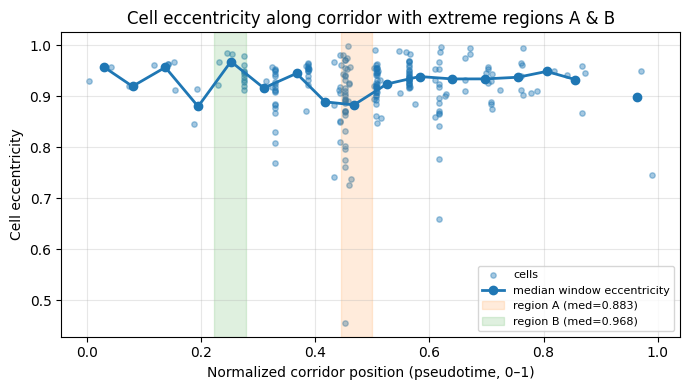

In [11]:
def plot_corridor_ecc_with_extreme_regions(
    cells_corridor,
    total_len,
    df_slide,
    prof,
    regions,
):
    s_vals = np.array([c["s_global"] for c in cells_corridor], float)
    ecc_vals = np.array([c["eccentricity"] for c in cells_corridor], float)
    pseudo_cells = s_vals / total_len

    fig, ax = plt.subplots(figsize=(7, 4))

    # all cells as dots
    ax.scatter(pseudo_cells, ecc_vals, s=15, alpha=0.4, label="cells")

    # median profile (from prof)
    ax.plot(
        prof["pseudo01"],
        prof["median_ecc"],
        "-o",
        color="tab:blue",
        linewidth=2,
        label="median window eccentricity",
    )

    # highlight regions A and B
    colors = {"A": "tab:orange", "B": "tab:green"}
    for label, info in regions.items():
        ax.axvspan(
            info["pseudo_lo"],
            info["pseudo_hi"],
            color=colors[label],
            alpha=0.15,
            label=f"region {label} (med={info['median_ecc']:.3f})",
        )

    ax.set_xlabel("Normalized corridor position (pseudotime, 0–1)")
    ax.set_ylabel("Cell eccentricity")
    ax.set_title("Cell eccentricity along corridor with extreme regions A & B")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)

    plt.tight_layout()
    plt.show()

# call:
plot_corridor_ecc_with_extreme_regions(
    cells_corridor,
    total_len,
    df_slide,
    prof,
    regions,
)


In [2]:
rep_idx, rep_win, xs0, yt0, yb0, length_px = pw.find_representative_window(
    window_infos=window_infos,
    centers_rot_map=centers_rot_map,
    SD=SD,
    mask=mask,
    mode="max_cells",   # or "median_x", "longest"
)

print("Representative window index:", rep_idx)
print("Window length (px):", length_px)


Representative window index: 266
Window length (px): 66.22423766765624


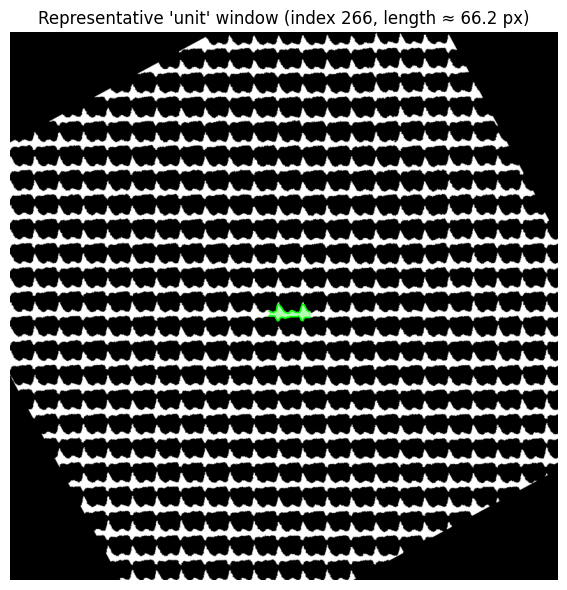

In [8]:
import matplotlib.pyplot as plt  # перезатираем plotly-псевдоним

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rot_img, cmap="gray")

ax.fill_between(xs0, yt0, yb0, alpha=0.3, color="lime")
ax.plot(xs0, yt0, color="lime", linewidth=1)
ax.plot(xs0, yb0, color="lime", linewidth=1)

ax.set_title(f"Representative 'unit' window (index {rep_idx}, length ≈ {length_px:.1f} px)")
ax.axis("off")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _as_scalar(x):
    """Свести всё (скаляр / массив) к одному float."""
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    return float(arr.ravel()[0])


def contains_point(
    cx: float,
    cy: float,
    xs: np.ndarray,
    yt: np.ndarray,
    yb: np.ndarray,
) -> bool:
    """
    Проверка: лежит ли точка (cx, cy) внутри «коридорной» полосы,
    заданной xs и границами yt(x), yb(x).
    Линейная интерполяция между соседними xs.
    """
    if cx < xs[0] or cx > xs[-1]:
        return False

    i = np.searchsorted(xs, cx)
    i = int(np.clip(i, 1, len(xs) - 1))

    x0, x1 = xs[i - 1], xs[i]
    if x1 == x0:
        t = 0.0
    else:
        t = (cx - x0) / (x1 - x0)

    y_top = yt[i - 1] + t * (yt[i] - yt[i - 1])
    y_bot = yb[i - 1] + t * (yb[i] - yb[i - 1])

    return y_top <= cy <= y_bot


def ecc_vs_position_all_windows(
    window_infos,
    centers_rot_map,
    SD,
    mask,
    ecc_col: str = "eccentricity",
    bin_size_px: float = 1.0,
):
    """
    Собираем пары (позиция вдоль окна, эксцентриситет) для ВСЕХ окон
    и ВСЕХ клеток в коридоре (mask=True), а затем бинируем по позиции.

    Возвращает DataFrame с колонками:
        pos_px, median_ecc, std_ecc, n_cells
    """

    df = SD.dataframe

    if ecc_col not in df.columns:
        raise KeyError(f"Column '{ecc_col}' not found in SD.dataframe")

    # эксцентриситет как скаляр
    ecc_series = df[ecc_col].apply(_as_scalar)

    # индексы строк, которые относятся к коридору
    corridor_idx = np.where(mask)[0]

    records = []

    # перебираем ВСЕ окна
    for w_idx, (win, xs, yt, yb) in enumerate(window_infos):
        xs = np.asarray(xs, float)
        yt = np.asarray(yt, float)
        yb = np.asarray(yb, float)

        # длина окна вдоль средней линии
        y_mid = 0.5 * (yt + yb)
        dx = np.diff(xs)
        dy = np.diff(y_mid)
        seg_lengths = np.sqrt(dx**2 + dy**2)
        s = np.concatenate(([0.0], np.cumsum(seg_lengths)))
        total_len = float(s[-1])
        if total_len <= 0:
            continue

        # клетки в этом окне
        for idx in corridor_idx:
            obj_id = df.index[idx]
            if obj_id not in centers_rot_map:
                continue

            cxr, cyr = centers_rot_map[obj_id]

            if not contains_point(cxr, cyr, xs, yt, yb):
                continue

            # позиция вдоль окна
            i = np.searchsorted(xs, cxr)
            i = int(np.clip(i, 1, len(xs) - 1))
            x0, x1 = xs[i - 1], xs[i]
            if x1 != x0:
                t = (cxr - x0) / (x1 - x0)
            else:
                t = 0.0
            s_cell = s[i - 1] + t * (s[i] - s[i - 1])

            ecc_val = ecc_series.iloc[idx]
            if not np.isfinite(ecc_val):
                continue

            records.append(
                {
                    "win_idx": w_idx,
                    "pos_px": float(s_cell),
                    "ecc": float(ecc_val),
                }
            )

    if not records:
        print("Во всех окнах не нашлось ни одной клетки.")
        return pd.DataFrame()

    df_pos = pd.DataFrame(records)

    # бин по позиции вдоль окна
    df_pos["pos_bin"] = np.round(df_pos["pos_px"] / bin_size_px).astype(int)

    grouped = (
        df_pos
        .groupby("pos_bin")
        .agg(
            pos_px=("pos_px", "mean"),
            median_ecc=("ecc", "median"),
            std_ecc=("ecc", "std"),
            n_cells=("ecc", "size"),
        )
        .reset_index(drop=True)
    )

    grouped["std_ecc"] = grouped["std_ecc"].fillna(0.0)

    return grouped


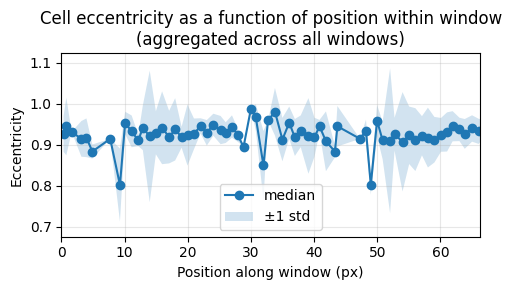

In [20]:
grouped_all = ecc_vs_position_all_windows(
    window_infos=window_infos,
    centers_rot_map=centers_rot_map,
    SD=SD,
    mask=mask,
    ecc_col="eccentricity",
    bin_size_px=1.0,
)

win0, xs0, yt0, yb0 = window_infos[0]
xs0 = np.asarray(xs0, float)
y_mid0 = 0.5 * (np.asarray(yt0, float) + np.asarray(yb0, float))
dx0 = np.diff(xs0)
dy0 = np.diff(y_mid0)
length_px0 = float(np.sqrt(dx0**2 + dy0**2).sum())

fig, ax = plot_ecc_vs_position_all_windows(grouped_all, length_px=length_px0)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def show_single_window_summary(
    rot_img,
    window_infos,
    centers_rot_map,
    SD,
    mask,
    win_idx: int = 0,
):
    """
    Нарисовать тот же самый «Single matched window (corridor cells)»,
    но для произвольного окна с индексом win_idx.
    """

    if not window_infos:
        print("window_infos пуст; нечего показывать.")
        return None, None

    if win_idx < 0 or win_idx >= len(window_infos):
        print(f"win_idx={win_idx} вне диапазона [0, {len(window_infos)-1}]")
        return None, None

    win0, xs0, yt0, yb0 = window_infos[win_idx]

    xs0 = np.asarray(xs0, dtype=float)
    yt0 = np.asarray(yt0, dtype=float)
    yb0 = np.asarray(yb0, dtype=float)

    # --- геометрия окна ---
    y_mid = 0.5 * (yt0 + yb0)
    dx = np.diff(xs0)
    dy = np.diff(y_mid)
    seg_lengths = np.sqrt(dx**2 + dy**2)
    length_px = float(seg_lengths.sum())

    widths = yb0 - yt0
    mean_width = float(widths.mean())
    min_width = float(widths.min())
    max_width = float(widths.max())

    n_steps = len(xs0)
    step_px = float(length_px / (n_steps - 1)) if n_steps > 1 else np.nan

    # --- глобальная статистика по коридору ---
    total_cells = len(SD.dataframe)
    cells_in_corridor = int(mask.sum())
    frac_cells = (cells_in_corridor / total_cells) if total_cells > 0 else 0.0

    # эксцентриситет
    ecc_line = "Eccentricity: column 'eccentricity' not found"
    if "eccentricity" in SD.dataframe.columns:
        ecc_corr_raw = SD.dataframe.loc[mask, "eccentricity"].dropna()
        ecc_all_raw = SD.dataframe["eccentricity"].dropna()

        def _as_scalar(x):
            arr = np.asarray(x)
            if arr.size == 0:
                return np.nan
            return float(arr.ravel()[0])

        ecc_corr = ecc_corr_raw.apply(_as_scalar).dropna()
        ecc_all = ecc_all_raw.apply(_as_scalar).dropna()

        if len(ecc_corr) > 0:
            mean_corr = float(ecc_corr.mean())
            std_corr = float(ecc_corr.std())
            mean_all = float(ecc_all.mean()) if len(ecc_all) > 0 else float("nan")
            ecc_line = (
                f"Mean eccentricity (corridor): {mean_corr:.3f} ± {std_corr:.3f} "
                f"(all cells: {mean_all:.3f})"
            )
        else:
            ecc_line = "Mean eccentricity (corridor): n/a (no values)"

    # --- вырезаем фон вокруг окна ---
    x0 = int(max(0, np.floor(xs0.min())))
    x1 = int(min(rot_img.shape[1], np.ceil(xs0.max())))
    y0 = int(max(0, np.floor(yt0.min())))
    y1 = int(min(rot_img.shape[0], np.ceil(yb0.max())))

    crop = rot_img[y0:y1, x0:x1]

    # --- рисуем 2-панельную фигуру ---
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    # ВЕРХ: окно + клетки
    ax0 = axes[0]
    ax0.imshow(crop, cmap="gray")
    ax0.fill_between(xs0 - x0, yt0 - y0, yb0 - y0, alpha=0.25)
    ax0.plot(xs0 - x0, yt0 - y0, linewidth=1)
    ax0.plot(xs0 - x0, yb0 - y0, linewidth=1)

    for obj_id, (cxr, cyr) in centers_rot_map.items():
        idx = SD.dataframe.index.get_loc(obj_id)
        if not mask[idx]:
            continue
        if (x0 <= cxr <= x1) and (y0 <= cyr <= y1):
            ax0.plot(cxr - x0, cyr - y0, "ro", markersize=4)

    ax0.set_title(f"Single matched window (corridor cells), win_idx={win_idx}")
    ax0.axis("off")

    # НИЗ: то же окно + текст со статистикой
    ax1 = axes[1]
    ax1.imshow(crop, cmap="gray")
    ax1.fill_between(xs0 - x0, yt0 - y0, yb0 - y0, alpha=0.15)
    ax1.plot(xs0 - x0, yt0 - y0, linewidth=1)
    ax1.plot(xs0 - x0, yb0 - y0, linewidth=1)
    ax1.axis("off")

    lines = [
        f"Length along corridor: {length_px:.1f} px",
        f"Width (mean / min / max): {mean_width:.1f} / {min_width:.1f} / {max_width:.1f} px",
        f"n steps: {n_steps}   pseudotime step ≈ {step_px:.2f} px",
        f"Cells in CORRIDOR region: {cells_in_corridor} of {total_cells} ({frac_cells*100:.1f}%)",
        ecc_line,
    ]
    for i, text in enumerate(lines):
        ax1.text(
            0.02,
            0.98 - 0.13 * i,
            text,
            transform=ax1.transAxes,
            va="top",
            ha="left",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    plt.tight_layout()
    plt.show()

    return fig, (ax0, ax1)


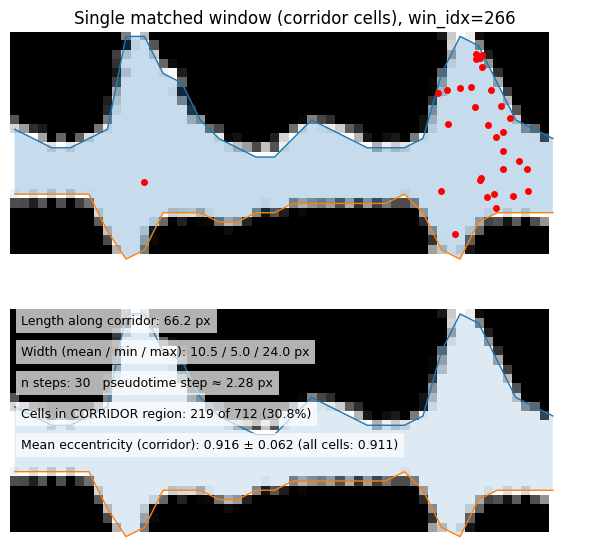

In [24]:
fig, axes = show_single_window_summary(
    rot_img,
    window_infos,
    centers_rot_map,
    SD,
    mask,
    win_idx=rep_idx,
)


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# если ещё не определён
def _as_scalar(x):
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    return float(arr.ravel()[0])


def ecc_vs_position_non_corridor(
    SD,
    centers_rot_map,
    mask,
    length_px,
    ecc_col="eccentricity",
    bin_size_px=1.0,
):
    """
    Строим профиль 'эксцентриситет vs псевдопозиция в окне'
    для клеток ВНЕ коридора.

    Позиция = x_rot клетки, линейно сжатый в диапазон [0, length_px].
    """

    df = SD.dataframe

    if ecc_col not in df.columns:
        raise KeyError(f"Column '{ecc_col}' not found in SD.dataframe")

    ecc_series = df[ecc_col].apply(_as_scalar)

    x_list = []
    ecc_list = []

    for idx, (obj_id, val) in enumerate(df["center"].items()):
        # пропускаем коридорные клетки — берём только "остальные"
        if mask[idx]:
            continue

        if obj_id not in centers_rot_map:
            continue

        x_rot, y_rot = centers_rot_map[obj_id]
        x_list.append(x_rot)

        ecc = ecc_series.iloc[idx]
        if np.isfinite(ecc):
            ecc_list.append(float(ecc))
        else:
            x_list.pop()   # если ecc NaN – не учитываем точку

    if not x_list:
        print("Нет ни одной клетки вне коридора с валидным эксцентриситетом.")
        return pd.DataFrame(columns=["pos_px", "median_ecc", "std_ecc", "n_cells"])

    x_arr  = np.asarray(x_list,  dtype=float)
    ecc_arr = np.asarray(ecc_list, dtype=float)

    # 1) сжимаем x в [0, length_px]
    x_min, x_max = float(x_arr.min()), float(x_arr.max())
    if x_max == x_min:
        x_norm = np.zeros_like(x_arr)
    else:
        x_norm = (x_arr - x_min) / (x_max - x_min) * float(length_px)

    # 2) бинним по псевдопозиции
    bins = np.arange(0.0, length_px + bin_size_px, bin_size_px)
    digitized = np.digitize(x_norm, bins) - 1

    rows = []
    for i in range(len(bins) - 1):
        m = digitized == i
        if not np.any(m):
            continue

        vals = ecc_arr[m]
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            continue

        pos_center = 0.5 * (bins[i] + bins[i + 1])
        rows.append(
            dict(
                pos_px=pos_center,
                median_ecc=float(np.median(vals)),
                std_ecc=float(np.std(vals)),
                n_cells=int(vals.size),
            )
        )

    grouped = pd.DataFrame(rows)
    return grouped


In [26]:
def plot_ecc_vs_position_aggregated(grouped, title_suffix="", x_lim=None, y_lim=None):
    if grouped.empty:
        print("grouped пустой – нечего рисовать.")
        return None, None

    fig, ax = plt.subplots(figsize=(5, 3))

    ax.plot(
        grouped["pos_px"],
        grouped["median_ecc"],
        marker="o",
        linestyle="-",
        label="median",
    )
    ax.fill_between(
        grouped["pos_px"],
        grouped["median_ecc"] - grouped["std_ecc"],
        grouped["median_ecc"] + grouped["std_ecc"],
        alpha=0.2,
        label="±1 std",
    )

    ax.set_xlabel("Position along window (px)")
    ax.set_ylabel("Eccentricity")
    ax.set_title(f"Cell eccentricity vs position {title_suffix}")
    ax.grid(True, alpha=0.3)
    ax.legend()

    if x_lim is not None:
        ax.set_xlim(*x_lim)
    if y_lim is not None:
        ax.set_ylim(*y_lim)

    plt.tight_layout()
    plt.show()
    return fig, ax


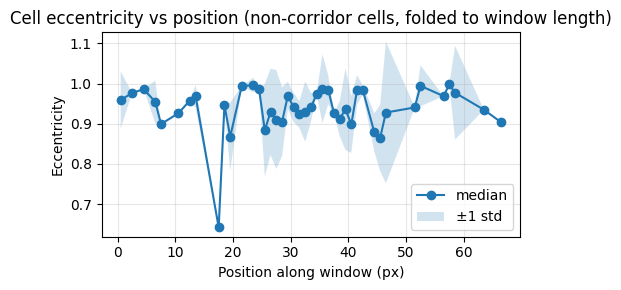

(<Figure size 500x300 with 1 Axes>,
 <Axes: title={'center': 'Cell eccentricity vs position (non-corridor cells, folded to window length)'}, xlabel='Position along window (px)', ylabel='Eccentricity'>)

: 

In [ ]:
# 1) уже есть
# SD, mask, window_infos, centers_rot_map, rot_img = ...

# 2) сначала получаем длину окна (как раньше)
win0, xs0, yt0, yb0 = window_infos[0]
xs0   = np.asarray(xs0, float)
y_mid = 0.5 * (np.asarray(yt0, float) + np.asarray(yb0, float))
dx    = np.diff(xs0)
dy    = np.diff(y_mid)
length_px0 = float(np.sqrt(dx**2 + dy**2).sum())   # ~66 px

# 3) профиль по коридорным клеткам (у тебя он уже был как grouped_all)
#    если нет под рукой – можно вызвать ecc_vs_position_all_windows(...)
# grouped_corridor = ecc_vs_position_all_windows(...)

# 4) профиль по НЕ-коридорным клеткам
grouped_non = ecc_vs_position_non_corridor(
    SD=SD,
    centers_rot_map=centers_rot_map,
    mask=mask,
    length_px=length_px0,
    ecc_col="eccentricity",
    bin_size_px=1.0,
)

# 5) рисуем
plot_ecc_vs_position_aggregated(
    grouped_non,
    title_suffix="(non-corridor cells, folded to window length)",
)
